In [217]:
import numpy as np
import matplotlib.pyplot as plt
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
from skimage.filters import gaussian, frangi, hessian, meijering, apply_hysteresis_threshold, threshold_otsu, threshold_local
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import confusion_matrix

import cv2

In [218]:
mask = None
img = None
manual1 = None

def load_mask(file_name):
    global mask
    mask_path = 'mask/' + file_name.split('.')[0] + '_mask.tif'
    if os.path.exists(mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
    else:
        print(f"Mask file {mask_path} does not exist.")
        mask = None
    
def load_image(file_name):
    global img
    image_path = 'images/' + file_name
    if os.path.exists(image_path):
        img = cv2.imread(image_path, cv2.IMREAD_COLOR_RGB)
        
    else:
        print(f"Image file {image_path} does not exist.")
        img = None
    
def load_manual(file_name):
    global manual1
    manual_path = 'manual1/' + file_name.split('.')[0] + '.tif'
    if os.path.exists(manual_path):
        manual1 = cv2.imread(manual_path, cv2.IMREAD_GRAYSCALE)
    else:
        print(f"Manual file {manual_path} does not exist.")
        manual1 = None

Dropdown(options=('01_dr.JPG', '01_g.jpg', '01_h.jpg', '02_dr.JPG', '02_g.jpg', '02_h.jpg', '03_dr.JPG', '03_g…

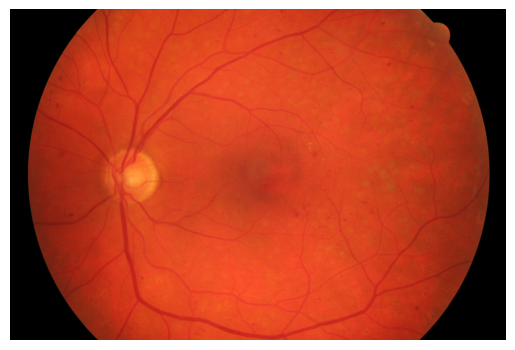

In [219]:
dir = 'images/'
directory_files = os.listdir(dir)
file_name = directory_files[0]

load_image(file_name)
load_mask(file_name)
load_manual(file_name)

picker = widgets.Dropdown(options=directory_files, disabled=False, )
display(picker)

plt.imshow(img)
plt.axis('off')

def on_change(change):
    clear_output()
    display(picker)
    global img, file_name
    file_name = change.new
    load_image(file_name)
    load_mask(file_name)
    load_manual(file_name)
    plt.imshow(img)
    plt.axis('off')
    


picker.observe(on_change, names='value')


(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

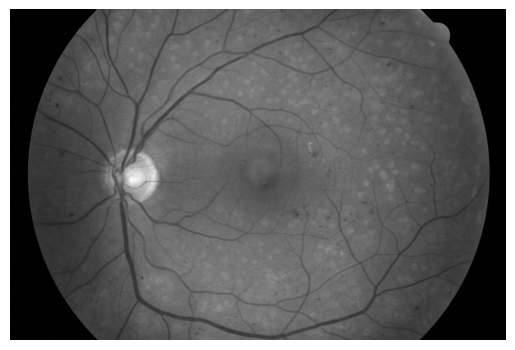

In [220]:
green_channel = img[:, :, 1]

plt.imshow(green_channel, cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

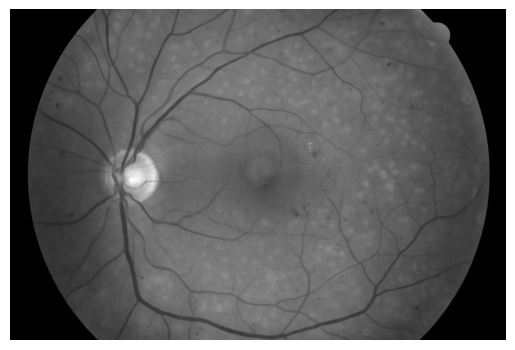

In [221]:
resized = cv2.resize(green_channel, (3504, 2336), interpolation=cv2.INTER_AREA)
normalized = cv2.normalize(resized, None, 0, 255, cv2.NORM_MINMAX)

noise_removed = cv2.fastNlMeansDenoising(normalized, None, 10, 7, 21)

plt.imshow(noise_removed, cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

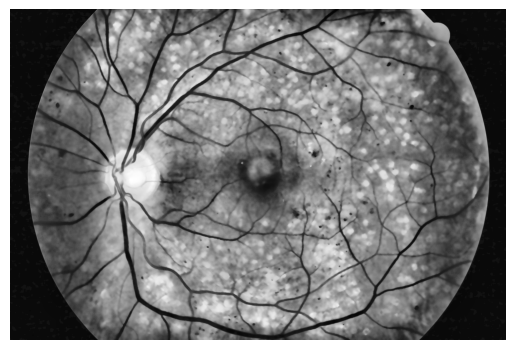

In [222]:
# clahe = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(128, 128))
clahe = cv2.createCLAHE(clipLimit=8.0)
equalized = clahe.apply(noise_removed.astype(np.uint8))
plt.imshow(equalized, cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

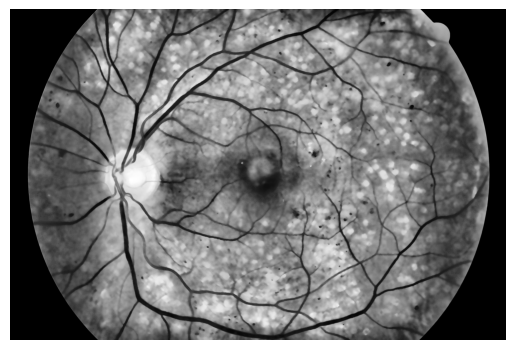

In [223]:
smoothed = cv2.GaussianBlur(equalized, (9, 9), 0)
sharpened = cv2.addWeighted(equalized, 1.5, smoothed, -0.5, 0)

preprocessed_image = cv2.bitwise_and(sharpened, mask)

plt.imshow(preprocessed_image, cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

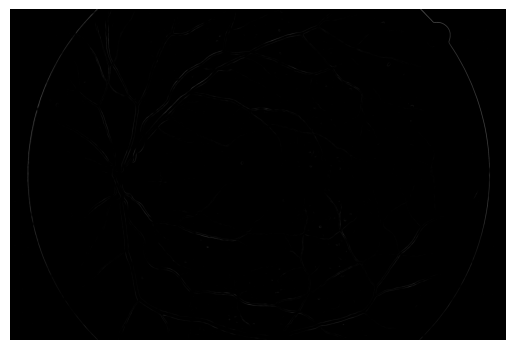

In [224]:
frangi_img = frangi(equalized, sigmas=(1, 15), alpha=0.5, beta=0.5, gamma=15)

# meijering_img = meijering(preprocessed_image, sigmas=range(1, 10))

plt.imshow(frangi_img, cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

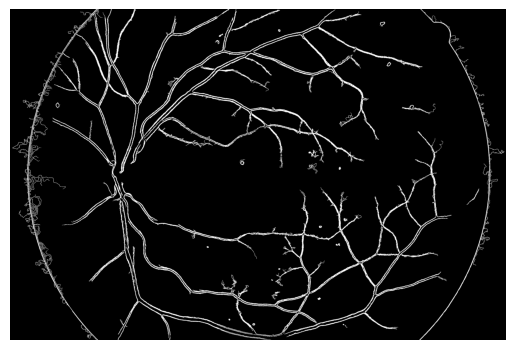

In [225]:
low = 0.001
high = 0.1

img_for_threshold = frangi_img.copy()

lowt = (img_for_threshold > low).astype(int)
hight = (img_for_threshold > high).astype(int)
hyst = apply_hysteresis_threshold(img_for_threshold, low, high).astype(np.uint8)

plt.imshow(hyst, cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

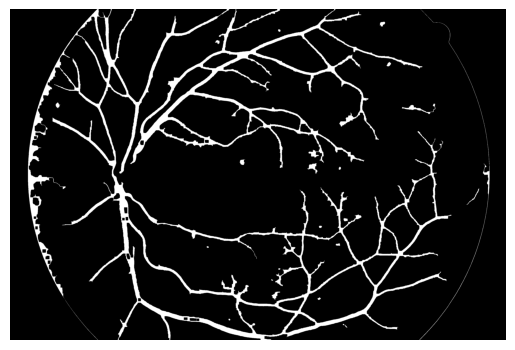

In [226]:
postprococessed_img = cv2.bitwise_and(hyst, mask)


postprococessed_img = cv2.morphologyEx(hyst, cv2.MORPH_BLACKHAT, np.ones((17,17),np.uint8), iterations=1)
postprococessed_img = cv2.bitwise_or(postprococessed_img, hyst)

postprococessed_img = cv2.bitwise_and(postprococessed_img, mask)


plt.imshow(postprococessed_img, cmap='gray')
plt.axis('off')

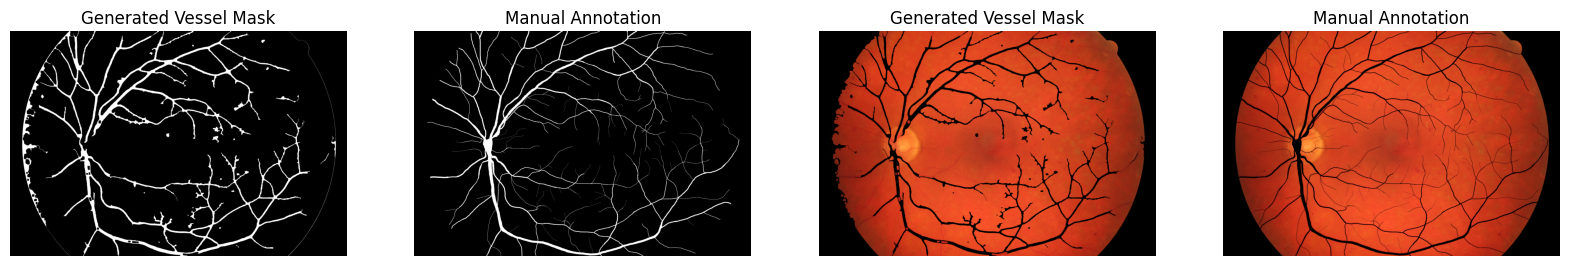

In [227]:
def compare_with_manual(generated_img, manual_img):
    # Ensure both images are the same size
    if generated_img.shape != manual_img.shape:
        manual_resized = cv2.resize(manual_img, (generated_img.shape[1], generated_img.shape[0]))
    else:
        manual_resized = manual_img

    # Normalize images to binary if needed
    gen_bin = (generated_img > 0).astype(np.uint8)
    man_bin = (manual_resized > 0).astype(np.uint8)

    # Show images side by side
    plt.figure(figsize=(20,10))
    plt.subplot(1,4,1)
    plt.imshow(gen_bin, cmap='gray')
    plt.title('Generated Vessel Mask')
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(man_bin, cmap='gray')
    plt.title('Manual Annotation')
    plt.axis('off')

    # Show images
    global img
    inv_gen = 1 - gen_bin
    gen_overlay = cv2.bitwise_and(img, img, mask=inv_gen)
    inv_man = 1 - man_bin
    man_overlay = cv2.bitwise_and(img, img, mask=inv_man)

    plt.subplot(1,4,3)
    plt.imshow(gen_overlay)
    plt.title('Generated Vessel Mask')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(man_overlay)
    plt.title('Manual Annotation')
    plt.axis('off')
    plt.show()


# Example usage:
compare_with_manual(postprococessed_img, manual1)

In [228]:
import numpy as np

def evaluate_segmentation(generated_img, manual_img):
    """
    Oblicza macierz pomyłek, accuracy, sensitivity, specificity oraz średnie dla niezrównoważonych danych.
    """
    # Upewnij się, że obrazy są binarne i tego samego rozmiaru
    if generated_img.shape != manual_img.shape:
        manual_img = cv2.resize(manual_img, (generated_img.shape[1], generated_img.shape[0]))
    gen_bin = (generated_img > 0).astype(np.uint8).ravel()
    man_bin = (manual_img > 0).astype(np.uint8).ravel()

    tn, fp, fn, tp = confusion_matrix(man_bin, gen_bin, labels=[0,1]).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # czułość
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # swoistość
    mean_arithmetic = (sensitivity + specificity) / 2
    mean_geometric = np.sqrt(sensitivity * specificity)

    print(f"Confusion matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Mean (arithmetic): {mean_arithmetic:.4f}")
    print(f"Mean (geometric): {mean_geometric:.4f}")

    return {
        "TP": tp, "TN": tn, "FP": fp, "FN": fn,
        "accuracy": accuracy,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "mean_arithmetic": mean_arithmetic,
        "mean_geometric": mean_geometric
    }

# Przykład użycia dla 5 obrazów:
results = []
for i, file_name in enumerate(directory_files[:5]):
    load_image(file_name)
    load_mask(file_name)
    load_manual(file_name)
    # ... tutaj pipeline segmentacji, np. postprococessed_img = ... ...
    # Załóżmy, że masz już postprococessed_img i manual1
    print(f"\nObraz: {file_name}")
    res = evaluate_segmentation(postprococessed_img, manual1)
    results.append(res)


Obraz: 01_dr.JPG
Confusion matrix: TP=298559, TN=7420242, FP=348820, FN=117723
Accuracy: 0.9430
Sensitivity (Recall): 0.7172
Specificity: 0.9551
Mean (arithmetic): 0.8362
Mean (geometric): 0.8276

Obraz: 01_g.jpg
Confusion matrix: TP=47990, TN=7038323, FP=599389, FN=499642
Accuracy: 0.8657
Sensitivity (Recall): 0.0876
Specificity: 0.9215
Mean (arithmetic): 0.5046
Mean (geometric): 0.2842

Obraz: 01_h.jpg
Confusion matrix: TP=70927, TN=6775004, FP=576452, FN=762961
Accuracy: 0.8364
Sensitivity (Recall): 0.0851
Specificity: 0.9216
Mean (arithmetic): 0.5033
Mean (geometric): 0.2800

Obraz: 02_dr.JPG
Confusion matrix: TP=52154, TN=7068241, FP=595225, FN=469724
Accuracy: 0.8699
Sensitivity (Recall): 0.0999
Specificity: 0.9223
Mean (arithmetic): 0.5111
Mean (geometric): 0.3036

Obraz: 02_g.jpg
Confusion matrix: TP=68679, TN=6996922, FP=578700, FN=541043
Accuracy: 0.8632
Sensitivity (Recall): 0.1126
Specificity: 0.9236
Mean (arithmetic): 0.5181
Mean (geometric): 0.3225
